In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.signal import periodogram
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import plotly.graph_objects as go
import shap
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from torchviz import make_dot


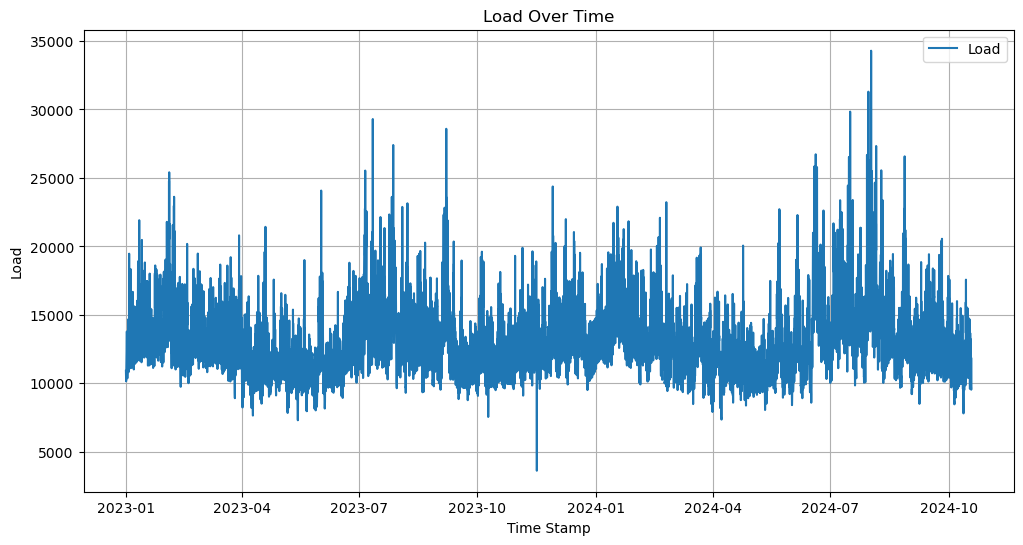

In [69]:
data = pd.read_csv("/Users/rohan/Documents/MSU/Classes/CMSE  802/project/cmse802_project/data/processed/combined_data.csv")

# Convert the 'Time Stamp' column to datetime
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Time Stamp'], data['Load'], label='Load')
plt.xlabel('Time Stamp')
plt.ylabel('Load')
plt.title('Load Over Time')
plt.legend()
plt.grid()
plt.show()

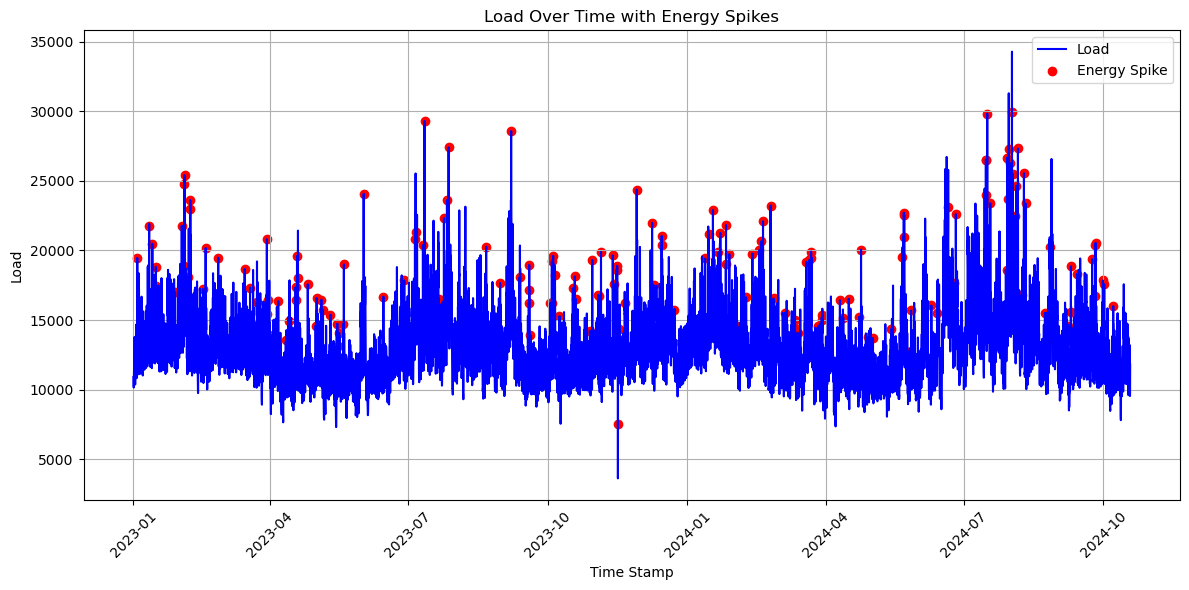

In [70]:
data['Previous Load'] = data['Load'].shift(1)

# Calculate energy spike boolean (1.3 times higher than the previous load)
data['Energy Spike'] = (data['Load'] > 1.3 * data['Previous Load'])

# Plotting the Load and Energy Spike
plt.figure(figsize=(12, 6))
plt.plot(data['Time Stamp'], data['Load'], label='Load', color='blue')
plt.scatter(data['Time Stamp'][data['Energy Spike']], data['Load'][data['Energy Spike']],
            color='red', label='Energy Spike')
plt.xlabel('Time Stamp')
plt.ylabel('Load')
plt.title('Load Over Time with Energy Spikes')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [71]:
import plotly.express as px

# Prepare data for interactive plotting
data['Energy Spike'] = data['Energy Spike'].astype(bool)  # Ensure boolean type

# Create an interactive plot with Plotly
fig = px.line(
    data,
    x='Time Stamp',
    y='Load',
    title='Load Over Time with Energy Spikes',
    labels={'Time Stamp': 'Time', 'Load': 'Load'},
    markers=True
)

# Add scatter points for energy spikes
spike_data = data[data['Energy Spike']]
fig.add_scatter(
    x=spike_data['Time Stamp'],
    y=spike_data['Load'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Energy Spike'
)

fig.update_layout(
    xaxis_title='Time Stamp',
    yaxis_title='Load',
    legend_title='Legend',
    template='plotly_white'
)

fig.show()


In [72]:
# Define a threshold for detecting spikes based on the difference
threshold = 2000  # Example threshold value

# Calculate the difference from the previous value
data['Difference'] = data['Load'].diff()

# Add a new column to detect spikes based on the threshold
data['Threshold Spike'] = (data['Difference'] > threshold)

# Plotting the Load with Threshold Spikes
fig = px.line(
    data,
    x='Time Stamp',
    y='Load',
    title='Load Over Time with Threshold-Based Spikes',
    labels={'Time Stamp': 'Time', 'Load': 'Load'},
    markers=True
)

# Add scatter points for threshold spikes
threshold_spike_data = data[data['Threshold Spike']]
fig.add_scatter(
    x=threshold_spike_data['Time Stamp'],
    y=threshold_spike_data['Load'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-up'),
    name='Threshold Spike'
)

fig.update_layout(
    xaxis_title='Time Stamp',
    yaxis_title='Load',
    legend_title='Legend',
    template='plotly_white'
)

fig.show()


In [73]:
# Plot both Energy Spikes and Threshold Spikes

fig = px.line(
    data,
    x='Time Stamp',
    y='Load',
    title='Load Over Time with Energy Spikes and Threshold Spikes',
    labels={'Time Stamp': 'Time', 'Load': 'Load'},
    markers=True
)

# Add scatter points for Energy Spikes
energy_spike_data = data[data['Energy Spike']]
fig.add_scatter(
    x=energy_spike_data['Time Stamp'],
    y=energy_spike_data['Load'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Energy Spike'
)

# Add scatter points for Threshold Spikes
threshold_spike_data = data[data['Threshold Spike']]
fig.add_scatter(
    x=threshold_spike_data['Time Stamp'],
    y=threshold_spike_data['Load'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-up'),
    name='Threshold Spike'
)

fig.update_layout(
    xaxis_title='Time Stamp',
    yaxis_title='Load',
    legend_title='Legend',
    template='plotly_white'
)

fig.show()


In [ ]:


# Split data into training (90%) and testing (10%)
train_size = int(len(data) * 0.99)
train, test = data[:train_size], data[train_size:]

# Prepare data for SARIMA
train_sarima = train.set_index('Time Stamp')['Load']
test_sarima = test.set_index('Time Stamp')['Load']

# SARIMA Model
sarima_model = SARIMAX(train_sarima, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_result = sarima_model.fit()

# Forecast using SARIMA
sarima_forecast = sarima_result.forecast(steps=len(test))

# Prepare data for Prophet
train_prophet = train[['Time Stamp', 'Load']].rename(columns={'Time Stamp': 'ds', 'Load': 'y'})
test_prophet = test[['Time Stamp', 'Load']].rename(columns={'Time Stamp': 'ds', 'Load': 'y'})

# Prophet Model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Forecast using Prophet
future_dates = test_prophet[['ds']]
prophet_forecast = prophet_model.predict(future_dates)

# Combine results into a DataFrame for comparison
forecast_results = pd.DataFrame({
    'Time Stamp': test['Time Stamp'],
    'Actual': test['Load'],
    'SARIMA Forecast': sarima_forecast.values,
    'Prophet Forecast': prophet_forecast['yhat'].values
})




/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54656D+00    |proj g|=  7.14199D-02

At iterate    5    f=  8.49309D+00    |proj g|=  9.16802D-03

At iterate   10    f=  8.49290D+00    |proj g|=  3.01347D-04

At iterate   15    f=  8.49279D+00    |proj g|=  1.22871D-03

At iterate   20    f=  8.47714D+00    |proj g|=  4.09809D-02

At iterate   25    f=  8.41817D+00    |proj g|=  5.96496D-03

At iterate   30    f=  8.41809D+00    |proj g|=  4.87717D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

21:24:33 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Load']])

# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 24  # Use last 24 hours as input to predict next value
x, y = create_sequences(scaled_data, seq_length)

# Split into training and testing data (90% training, 10% testing)
train_size = int(len(x) * 0.99)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 2
model = LSTM(input_size, hidden_size, output_size, num_layers)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 20
batch_size = 16

train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Testing
model.eval()
with torch.no_grad():
    train_predictions = model(x_train).squeeze().numpy()
    test_predictions = model(x_test).squeeze().numpy()

# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))




SyntaxError: unmatched ']' (1829234853.py, line 90)

In [76]:

forecast_results["LSTM Forecast"]=test_predictions

In [ ]:


# Create a Plotly figure for visualization
fig = go.Figure()

# Add actual values trace
fig.add_trace(go.Scatter(
    x=forecast_results['Time Stamp'],
    y=forecast_results['Actual'],
    mode='lines+markers',
    name='Actual',
    line=dict(color='blue'),
))

# Add SARIMA forecast trace
fig.add_trace(go.Scatter(
    x=forecast_results['Time Stamp'],
    y=forecast_results['SARIMA Forecast'],
    mode='lines',
    name='SARIMA Forecast',
    line=dict(color='green', dash='dash')
))

# Add Prophet forecast trace
fig.add_trace(go.Scatter(
    x=forecast_results['Time Stamp'],
    y=forecast_results['Prophet Forecast'],
    mode='lines',
    name='Prophet Forecast',
    line=dict(color='red', dash='dot')
))

# Add LSTM forecast trace
fig.add_trace(go.Scatter(
    x=forecast_results['Time Stamp'],
    y=forecast_results['LSTM Forecast'],
    mode='lines',
    name='LSTM Forecast',
    line=dict(color='orange', dash='solid')
))

# Update layout for clarity
fig.update_layout(
    title='Forecast Comparison: Actual vs SARIMA vs Prophet vs LSTM',
    xaxis_title='Time Stamp',
    yaxis_title='Load',
    legend_title='Legend',
    template='plotly_white',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)



# Show interactive plot
fig.show()


In [78]:
from sklearn.metrics import mean_absolute_error

# Assuming the following variables contain test results:
# - actual_values: The actual values of the test set
# - sarimax_forecast: Predictions from SARIMAX
# - prophet_forecast: Predictions from Prophet
# - lstm_forecast: Predictions from LSTM

actual_values=forecast_results['Actual']
sarimax_forecast=forecast_results['SARIMA Forecast']
lstm_values=forecast_results['LSTM Forecast']

# Calculate MAE for each model
mae_sarimax = mean_absolute_error(actual_values, sarimax_forecast[:len(actual_values)])
mae_prophet = mean_absolute_error(actual_values, prophet_forecast['yhat'][:len(actual_values)])
mae_lstm = mean_absolute_error(actual_values, lstm_values[:len(actual_values)])

# Store results in a dictionary
mae_results = {
    'SARIMAX': mae_sarimax,
    'Prophet': mae_prophet,
    'LSTM': mae_lstm
}

# Find the best model based on MAE
best_model = min(mae_results, key=mae_results.get)

# Print the MAE for each model and the best model
print("Mean Absolute Error (MAE) for each model:")
for model, mae in mae_results.items():
    print(f"{model}: {mae:.4f}")

print(f"\nBest model based on MAE: {best_model} with MAE = {mae_results[best_model]:.4f}")


Mean Absolute Error (MAE) for each model:
SARIMAX: 1258.1465
Prophet: 1323.4835
LSTM: 1274.7828

Best model based on MAE: SARIMAX with MAE = 1258.1465


In [52]:
data.columns

Index(['Load', 'normalized_load', 'coordinates (lat,lon)', 'model (name)',
       'model elevation (surface)', 'utc_offset (hrs)', 'temperature (degC)',
       'wind_speed (m\/s)', 'total_precipitation (mm of water equivalent)',
       'Previous Load', 'Energy Spike', 'Difference', 'Threshold Spike'],
      dtype='object')

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Prepare data
data['Time Stamp'] = pd.to_datetime(data.index)
data.set_index('Time Stamp', inplace=True)

# Define target and exogenous variables
target = data['Load']
exog = data[['temperature (degC)', 'wind_speed (m\/s)', 'total_precipitation (mm of water equivalent)']]

# Split into training and testing sets
train_size = int(len(target) * 0.99)
target_train, target_test = target[:train_size], target[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# Train SARIMAX model
sarimax_model = SARIMAX(target_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarimax_result = sarimax_model.fit()

# Forecast
sarimax_forecast = sarimax_result.forecast(steps=len(target_test), exog=exog_test)

# Evaluate
print(sarimax_forecast)


<>:10: SyntaxWarning:

invalid escape sequence '\/'

<>:10: SyntaxWarning:

invalid escape sequence '\/'

/var/folders/rw/0tvxrjxd6xgg15ts3dc0z8p80000gn/T/ipykernel_93457/1770930205.py:10: SyntaxWarning:

invalid escape sequence '\/'

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54581D+00    |proj g|=  7.14161D-02


 This problem is unconstrained.



At iterate    5    f=  8.49229D+00    |proj g|=  3.18706D-03

At iterate   10    f=  8.49217D+00    |proj g|=  5.87972D-04

At iterate   15    f=  8.49201D+00    |proj g|=  7.25772D-03

At iterate   20    f=  8.47160D+00    |proj g|=  1.07301D-01

At iterate   25    f=  8.41722D+00    |proj g|=  6.05963D-03

At iterate   30    f=  8.41699D+00    |proj g|=  3.86258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     36      1     0     0   9.201D-06   8.417D+00
  F =   8.4169868267754051     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
15603     9441.517499
15604     9824.937652
15605  

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [59]:
data["Time Stamp"]=data.index

In [63]:
from prophet import Prophet
import pandas as pd

# Prepare data for Prophet
prophet_data = data[['Time Stamp', 'Load', 'temperature (degC)', 'wind_speed (m\/s)', 'total_precipitation (mm of water equivalent)']].rename(columns={
    'Time Stamp': 'ds', 'Load': 'y'
})

# Initialize Prophet model
prophet_model = Prophet()
prophet_model.add_regressor('temperature (degC)')
prophet_model.add_regressor('wind_speed (m\/s)')
prophet_model.add_regressor('total_precipitation (mm of water equivalent)')

# Train model
prophet_model.fit(prophet_data)

# Forecast
future = prophet_data[['ds', 'temperature (degC)', 'wind_speed (m\/s)', 'total_precipitation (mm of water equivalent)']]
prophet_forecast = prophet_model.predict(future)

# Display forecast
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


<>:5: SyntaxWarning:

invalid escape sequence '\/'

<>:12: SyntaxWarning:

invalid escape sequence '\/'

<>:19: SyntaxWarning:

invalid escape sequence '\/'

<>:5: SyntaxWarning:

invalid escape sequence '\/'

<>:12: SyntaxWarning:

invalid escape sequence '\/'

<>:19: SyntaxWarning:

invalid escape sequence '\/'

/var/folders/rw/0tvxrjxd6xgg15ts3dc0z8p80000gn/T/ipykernel_93457/3447581694.py:5: SyntaxWarning:

invalid escape sequence '\/'

/var/folders/rw/0tvxrjxd6xgg15ts3dc0z8p80000gn/T/ipykernel_93457/3447581694.py:12: SyntaxWarning:

invalid escape sequence '\/'

/var/folders/rw/0tvxrjxd6xgg15ts3dc0z8p80000gn/T/ipykernel_93457/3447581694.py:19: SyntaxWarning:

invalid escape sequence '\/'

21:04:53 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing


                       ds          yhat    yhat_lower    yhat_upper
0     2023-01-01 00:00:00  11488.997085   9210.443996  13674.290528
1     2023-01-01 01:00:00  11085.356088   8688.250692  13487.005429
2     2023-01-01 02:00:00  10817.491249   8542.677810  13088.058258
3     2023-01-01 03:00:00  10707.998744   8428.228613  13040.229679
4     2023-01-01 04:00:00  10861.283749   8725.553421  13266.750653
...                   ...           ...           ...           ...
15756 2024-10-18 13:00:00  12560.265201  10130.389223  14683.674222
15757 2024-10-18 14:00:00  12727.307993  10417.267223  15021.275111
15758 2024-10-18 15:00:00  12941.026440  10629.485175  15390.684189
15759 2024-10-18 16:00:00  13249.008889  11081.227374  15446.073185
15760 2024-10-18 17:00:00  13629.742515  11296.297836  16008.194482

[15761 rows x 4 columns]


<>:8: SyntaxWarning:

invalid escape sequence '\/'

<>:8: SyntaxWarning:

invalid escape sequence '\/'

/var/folders/rw/0tvxrjxd6xgg15ts3dc0z8p80000gn/T/ipykernel_93457/2397563447.py:8: SyntaxWarning:

invalid escape sequence '\/'



Epoch 1/20, Loss: 0.002730119042098522
Epoch 2/20, Loss: 0.0025747104082256556
Epoch 3/20, Loss: 0.002569908043369651
Epoch 4/20, Loss: 0.002591979457065463
Epoch 5/20, Loss: 0.002628394402563572
Epoch 6/20, Loss: 0.002680026926100254
Epoch 7/20, Loss: 0.0027413847856223583
Epoch 8/20, Loss: 0.002807437442243099
Epoch 9/20, Loss: 0.002868891693651676
Epoch 10/20, Loss: 0.0029249920044094324
Epoch 11/20, Loss: 0.0029701644089072943
Epoch 12/20, Loss: 0.00299198180437088
Epoch 13/20, Loss: 0.002930422080680728
Epoch 14/20, Loss: 0.0028688767924904823
Epoch 15/20, Loss: 0.004952445160597563
Epoch 16/20, Loss: 0.003341783070936799
Epoch 17/20, Loss: 0.0033549792133271694
Epoch 18/20, Loss: 0.0034823818132281303
Epoch 19/20, Loss: 0.0030969856306910515
Epoch 20/20, Loss: 0.004829987417906523


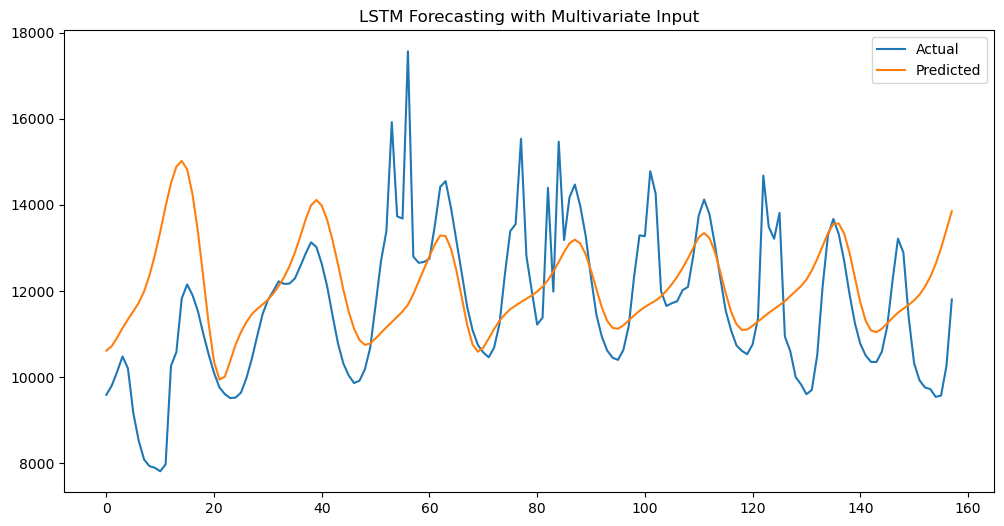

In [ ]:

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Load', 'temperature (degC)', 'wind_speed (m\/s)', 'total_precipitation (mm of water equivalent)']])

# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length, 1:])  # Exclude 'Load' as input features
        y.append(data[i+seq_length, 0])    # 'Load' as target
    return np.array(x), np.array(y)

seq_length = 24
x, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets
train_size = int(len(x) * 0.99)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = x_train.shape[2]  # Number of features
hidden_size = 50
output_size = 1
num_layers = 2
model = LSTM(input_size, hidden_size, output_size, num_layers)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 20
batch_size = 16

for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Testing
model.eval()
with torch.no_grad():
    test_predictions = model(x_test).squeeze().numpy()

# Inverse transform predictions
test_predictions = scaler.inverse_transform(
    np.concatenate([test_predictions.reshape(-1, 1), np.zeros((len(test_predictions), 3))], axis=1)
)[:, 0]
y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.numpy().reshape(-1, 1), np.zeros((len(y_test), 3))], axis=1)
)[:, 0]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title('LSTM Forecasting with Multivariate Input')
plt.legend()
plt.show()


In [ ]:


# Assuming results from SARIMAX, Prophet, and LSTM forecasts are stored in:
# - sarimax_forecast: SARIMAX predictions
# - prophet_forecast: Prophet predictions
# - test_predictions: LSTM predictions
# - y_test_actual: Actual values from test set

# Prepare data for plotting
actual_values = y_test_actual  # Actual test set values
sarimax_values = sarimax_forecast[:len(y_test_actual)].values  # SARIMAX forecast
prophet_values = prophet_forecast['yhat'][:len(y_test_actual)].values  # Prophet forecast
lstm_values = test_predictions  # LSTM forecast

# Create a Plotly figure
fig = go.Figure()

# Add actual values
fig.add_trace(go.Scatter(
    y=actual_values,
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

# Add SARIMAX forecast
fig.add_trace(go.Scatter(
    y=sarimax_values,
    mode='lines',
    name='SARIMAX Forecast',
    line=dict(color='green', dash='dash')
))

# Add Prophet forecast
fig.add_trace(go.Scatter(
    y=prophet_values,
    mode='lines',
    name='Prophet Forecast',
    line=dict(color='red', dash='dot')
))

# Add LSTM forecast
fig.add_trace(go.Scatter(
    y=lstm_values,
    mode='lines',
    name='LSTM Forecast',
    line=dict(color='orange', dash='solid')
))

# Update layout
fig.update_layout(
    title='Forecast Comparison: Actual vs SARIMAX vs Prophet vs LSTM',
    xaxis_title='Time Steps',
    yaxis_title='Load',
    legend_title='Legend',
    template='plotly_white'
)

# Show the plot
fig.show()


In [ ]:

# Assuming the following variables contain test results:
# - actual_values: The actual values of the test set
# - sarimax_forecast: Predictions from SARIMAX
# - prophet_forecast: Predictions from Prophet
# - lstm_forecast: Predictions from LSTM

# Calculate MAE for each model
mae_sarimax = mean_absolute_error(actual_values, sarimax_forecast[:len(actual_values)])
mae_prophet = mean_absolute_error(actual_values, prophet_forecast['yhat'][:len(actual_values)])
mae_lstm = mean_absolute_error(actual_values, lstm_values[:len(actual_values)])

# Store results in a dictionary
mae_results = {
    'SARIMAX': mae_sarimax,
    'Prophet': mae_prophet,
    'LSTM': mae_lstm
}

# Find the best model based on MAE
best_model = min(mae_results, key=mae_results.get)

# Print the MAE for each model and the best model
print("Mean Absolute Error (MAE) for each model:")
for model_, mae in mae_results.items():
    print(f"{model_}: {mae:.4f}")

print(f"\nBest model based on MAE: {best_model} with MAE = {mae_results[best_model]:.4f}")


Mean Absolute Error (MAE) for each model:
SARIMAX: 1176.2711
Prophet: 2399.1671
LSTM: 1274.7828

Best model based on MAE: SARIMAX with MAE = 1176.2711


In [ ]:


# Create a dummy input tensor to visualize the model structure
dummy_input = torch.zeros((1, seq_length, input_size), dtype=torch.float32)

# Generate the visualization of the model
model_structure = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the visualization
model_structure.format = "png"
model_structure.render("lstm_model_structure")

# Open and display the model structure
from PIL import Image
Image.open("lstm_model_structure.png").show()

/Users/rohan/anaconda3/envs/cmse802/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning:

Image size (133939197 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



In [83]:
type(model)

str

In [ ]:

# Data
models = ['SARIMAX', 'LSTM', 'Prophet'][::-1]
mae_values = [1176.2711, 1274.7828,2399.1671, ][::-1]

fig = go.Figure(data=[
    go.Bar(
        name='MAE',
        x=mae_values,  # Use MAE values on the x-axis
        y=models,  # Use model names on the y-axis
        text=mae_values,  # Display MAE values on bars
        textposition='auto',
        orientation='h',  # Horizontal orientation
        width=0.5  # Control bar thickness
    )
])
# Update layout
fig.update_layout(
    xaxis_title="Models",
    yaxis_title="Mean Absolute Error (MAE)",
    template="plotly_white",
    font=dict(size=14),
    width=600,  # Set plot width
    height=300  # Set plot height
)

# Show plot
fig.show()


In [103]:
data.columns

Index(['Time Stamp', 'Load', 'normalized_load', 'coordinates (lat,lon)',
       'model (name)', 'model elevation (surface)', 'utc_offset (hrs)',
       'temperature (degC)', 'wind_speed (m\/s)',
       'total_precipitation (mm of water equivalent)', 'Previous Load',
       'Energy Spike', 'Difference', 'Threshold Spike'],
      dtype='object')

In [ ]:
# Combine 'Energy Spike' and 'Threshold Spike' columns to create a new 'Spike' column
data["Spike"] = data["Energy Spike"] + data["Threshold Spike"]

# Create lag features for 'Load' column
data['Lag_2'] = data['Load'].shift(2)  # Shift by 2 time steps
data['Lag_3'] = data['Load'].shift(3)  # Shift by 3 time steps
data['Lag_24'] = data['Load'].shift(24)  # Shift by 24 time steps (1 day if hourly data)
data['Lag_48'] = data['Load'].shift(48)  # Shift by 48 time steps (2 days if hourly data)

In [108]:
data["Spike"]

0        False
1        False
2        False
3        False
4        False
         ...  
15756    False
15757    False
15758    False
15759    False
15760    False
Name: Spike, Length: 15761, dtype: bool

<>:9: SyntaxWarning:

invalid escape sequence '\/'

<>:9: SyntaxWarning:

invalid escape sequence '\/'

/var/folders/rw/0tvxrjxd6xgg15ts3dc0z8p80000gn/T/ipykernel_93457/1145265762.py:9: SyntaxWarning:

invalid escape sequence '\/'



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 189, number of negative: 2442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1875
[LightGBM] [Info] Number of data points in the train set: 2631, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 316, number of negative: 4941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1935
[LightGBM] [Info] Number of data points in the train set: 5257, number of used features: 

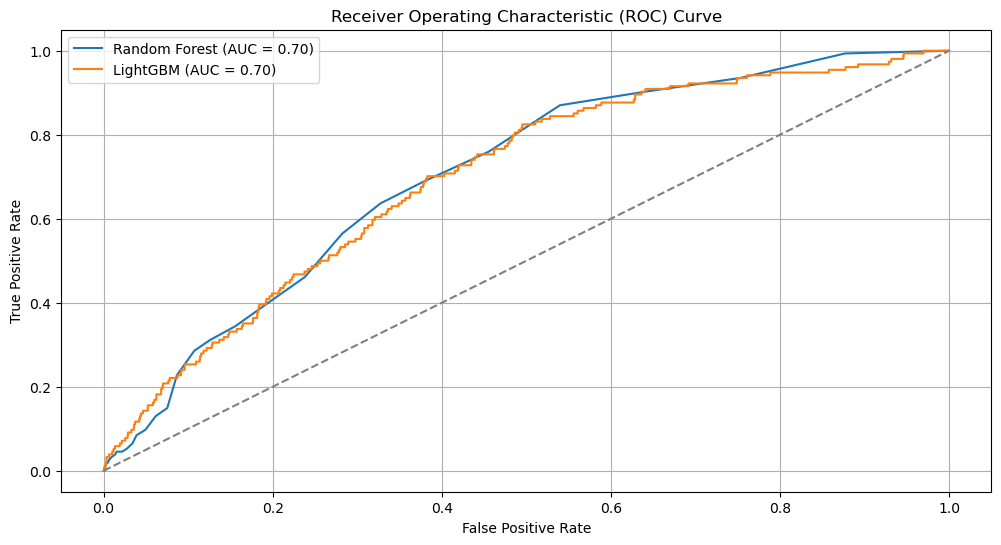

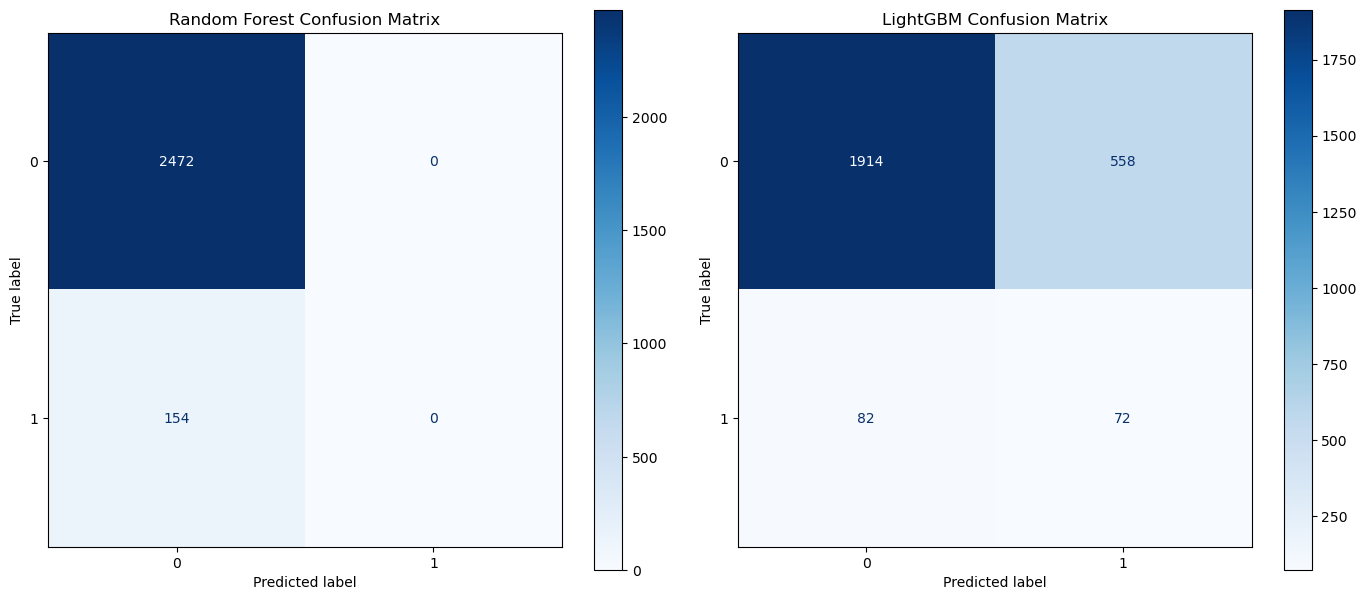

In [ ]:

# Define features (X) and target (y)
X = data[['temperature (degC)', 'wind_speed (m\/s)',
        'total_precipitation (mm of water equivalent)', 'Previous Load', 'Lag_2','Lag_3','Lag_24','Lag_48']]
y = data['Spike']  # Boolean target column

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize models with class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')

# Store AUROC scores
roc_data = {'Random Forest': [], 'LightGBM': []}

# Variables for last fold
final_rf_pred, final_rf_proba = None, None
final_lgbm_pred, final_lgbm_proba = None, None
final_y_test = None

# Cross-validation loop
for train_index, test_index in tscv.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Random Forest
    rf_model.fit(X_train, y_train)
    rf_proba = rf_model.predict_proba(X_test)[:, 1]
    rf_pred = rf_model.predict(X_test)
    roc_data['Random Forest'].append(roc_auc_score(y_test, rf_proba))
    
    # LightGBM
    lgbm_model.fit(X_train, y_train)
    lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]
    lgbm_pred = lgbm_model.predict(X_test)
    roc_data['LightGBM'].append(roc_auc_score(y_test, lgbm_proba))
    
    # Store last fold predictions for confusion matrix
    final_rf_pred, final_rf_proba = rf_pred, rf_proba
    final_lgbm_pred, final_lgbm_proba = lgbm_pred, lgbm_proba
    final_y_test = y_test

# Plot AUROC
plt.figure(figsize=(12, 6))
fpr_rf, tpr_rf, _ = roc_curve(final_y_test, final_rf_proba)
fpr_lgbm, tpr_lgbm, _ = roc_curve(final_y_test, final_lgbm_proba)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})")
plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC = {auc(fpr_lgbm, tpr_lgbm):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(final_y_test, final_rf_pred)).plot(ax=axes[0], cmap='Blues')
axes[0].title.set_text("Random Forest Confusion Matrix")

# LightGBM Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(final_y_test, final_lgbm_pred)).plot(ax=axes[1], cmap='Blues')
axes[1].title.set_text("LightGBM Confusion Matrix")

plt.tight_layout()
plt.show()


<>:16: SyntaxWarning:

invalid escape sequence '\/'

<>:16: SyntaxWarning:

invalid escape sequence '\/'

/var/folders/rw/0tvxrjxd6xgg15ts3dc0z8p80000gn/T/ipykernel_93457/2736158047.py:16: SyntaxWarning:

invalid escape sequence '\/'



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 189, number of negative: 2442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1875
[LightGBM] [Info] Number of data points in the train set: 2631, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 316, number of negative: 4941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1935
[LightGBM] [Info] Number of data points in the train set: 5257, number of used features: 

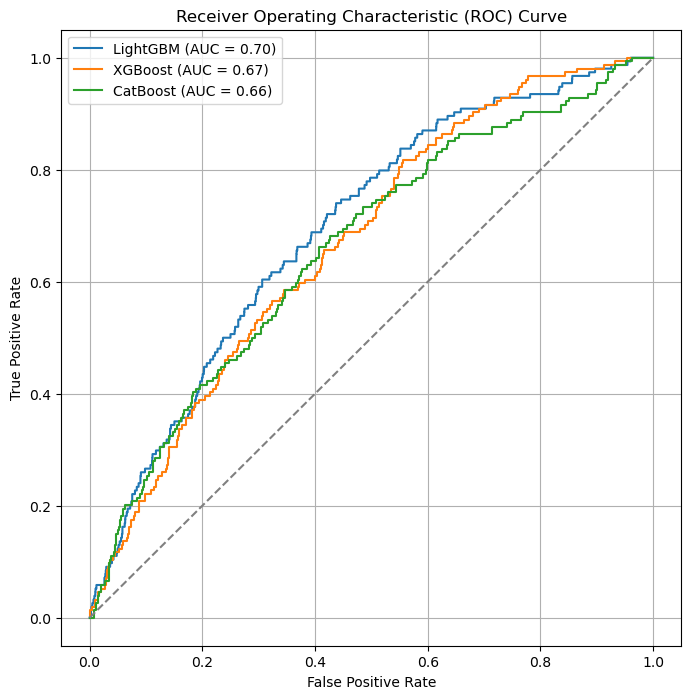

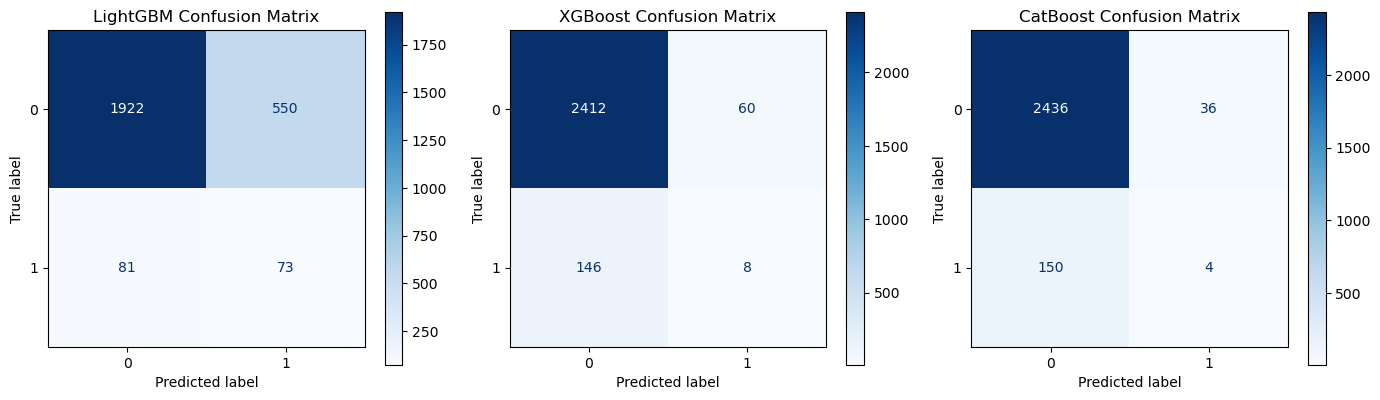

Average AUROC for Each Model:
LightGBM: 0.6401
XGBoost: 0.6162
CatBoost: 0.6319


In [ ]:


# Define features (X) and target (y)
X = data[['temperature (degC)', 'wind_speed (m\/s)',
          'total_precipitation (mm of water equivalent)', 'Previous Load', 'Lag_2', 'Lag_3', 'Lag_24', 'Lag_48']]
y = data['Spike']  # Boolean target column

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize classifiers with class weights
models = {
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=5),  # Adjust `scale_pos_weight` as needed
    "CatBoost": CatBoostClassifier(random_state=42, class_weights=[1, 5], verbose=0)
}

# Store AUROC scores and last fold predictions
roc_data = {name: [] for name in models.keys()}
last_fold_preds = {}

# Cross-validation loop
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for name, model in models.items():
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]
        pred = model.predict(X_test)
        
        roc_data[name].append(roc_auc_score(y_test, proba))
        
        # Store predictions for the last fold
        if test_index[-1] == len(y) - 1:
            last_fold_preds[name] = (pred, proba)

# Plot AUROC
plt.figure(figsize=(8, 8))
for name, (pred, proba) in last_fold_preds.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes = axes.ravel()

for i, (name, (pred, proba)) in enumerate(last_fold_preds.items()):
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(ax=axes[i], cmap='Blues')
    axes[i].title.set_text(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

# Print Average AUROC for Each Model
print("Average AUROC for Each Model:")
for name, scores in roc_data.items():
    print(f"{name}: {sum(scores) / len(scores):.4f}")


 99%|===================| 15542/15761 [00:45<00:00]        

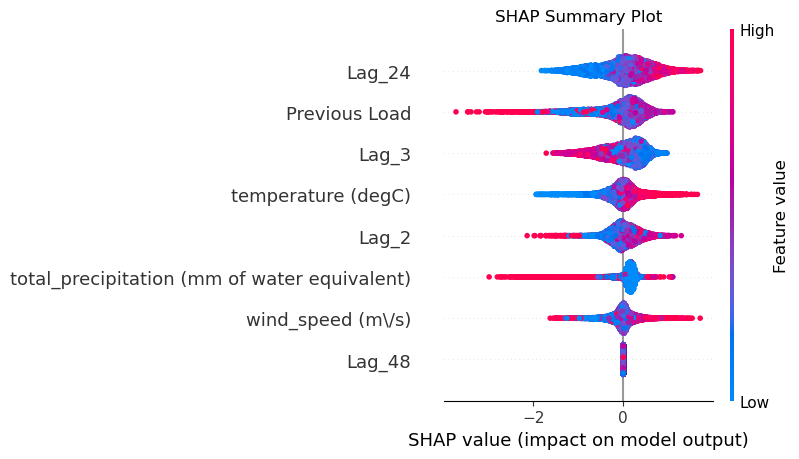

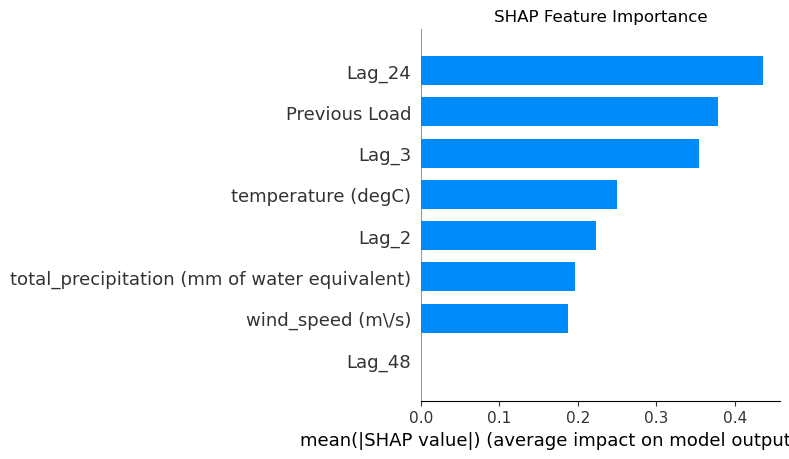

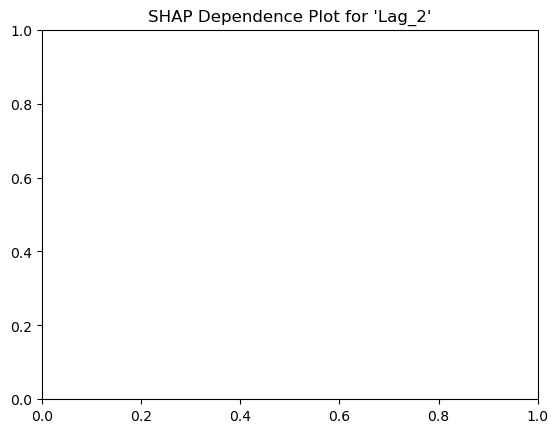

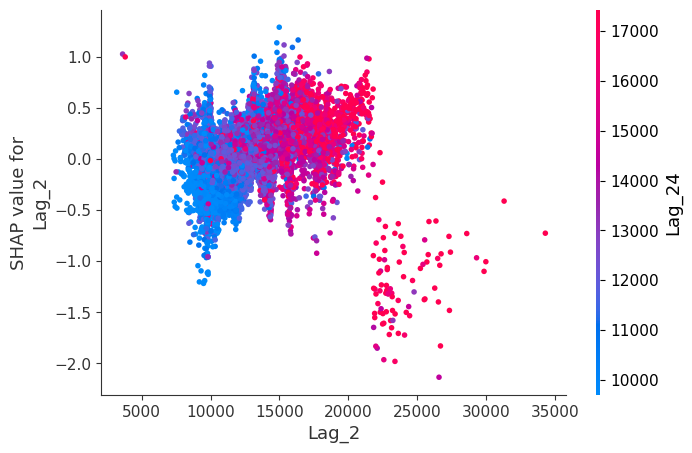

In [ ]:


# Example: Assuming you have already trained a LightGBM model
model = models["LightGBM"]  # Replace with "XGBoost" or "CatBoost" if needed

# Create a SHAP explainer
explainer = shap.Explainer(model, X)  # SHAP supports tree-based models natively

# Calculate SHAP values
shap_values = explainer(X,check_additivity=False)

# Summary Plot
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X)

# Feature Importance Bar Plot
plt.title("SHAP Feature Importance")
shap.summary_plot(shap_values, X, plot_type="bar")

# Dependence Plot for a Single Feature (replace 'Lag_2' with your feature name)
plt.title("SHAP Dependence Plot for 'Lag_2'")
shap.dependence_plot("Lag_2", shap_values.values, X)


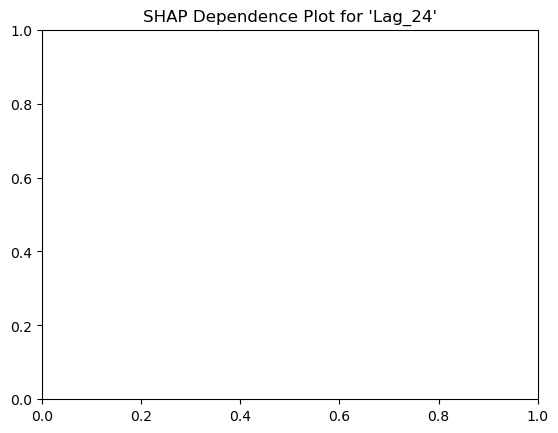

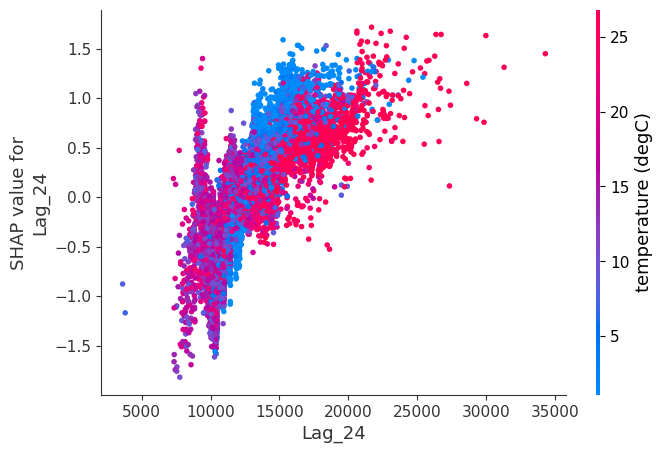

In [156]:
plt.title("SHAP Dependence Plot for 'Lag_24'")
shap.dependence_plot("Lag_24", shap_values.values, X)